# Compare Novel and Conventional Radios

This notebook looks at how we can compare a trained radio with a conventional radio. In this case we compare our `DenseRadio` with DSSS-BPSK. 

We begin as always with our imports.

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import torch
from IPython.display import Image
from torch import nn
from tqdm import tqdm

from torchradio import DeviceLogs, Receiver, Transmitter
from torchradio.algorithm import DSSS
from torchradio.algorithm.example import DenseRadio
from torchradio.env.null import ControlledSNREnvironment, RandomBoundedSNREnvironment

Let's add some seeds for reproducibility.

In [2]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)  # noqa: NPY002

Let's define a radio similar to the one from [Train Basic Communications](./train_basic_comms.ipynb). In this case we select the arguments `(8, 13)` so that it has the same throughout as the DSSS-BPSK algorithm that we will define later.

We use a new environment here called `RandomBoundedSNREnvironment`, which will select random SNRs between -10 and +10dB for each simulation.

In [3]:
dense_radio = DenseRadio(
    8,
    13,
)  # to have same throughput as DSSS-BPSK with Barker code 13
transmitters = {"dense_tx": Transmitter(dense_radio.tx)}
receivers = {"dense_rx": Receiver(dense_radio.rx)}
train_env = RandomBoundedSNREnvironment(-20, 0)
train_env.place(transmitters, receivers)

We train the radio like before...

In [4]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(dense_radio.parameters(), lr=1e-4)
n_iterations = 20_000
batch_size = 10
n_timesteps = 128
losses = []


def _train(
    n_timesteps: int,
    batch_size: int,
) -> dict[str, float]:
    optimizer.zero_grad()

    device_logs = train_env.simulate(n_timesteps, batch_size)

    tx_bits = device_logs.tx["dense_tx"].metadata["bits"]
    rx_outputs = device_logs.rx["dense_rx"]["bit_probabilities"]
    rx_bits = device_logs.rx["dense_rx"]["bits"]

    # compute loss, gradient and update parameters
    loss = loss_fn(rx_outputs, tx_bits.float())
    loss.backward()
    optimizer.step()

    return {
        "loss": loss.detach().numpy(),
        "accuracy": np.mean((tx_bits == rx_bits).numpy()),
    }


for _ in tqdm(range(n_iterations)):
    train_logs = _train(n_timesteps, batch_size)
    losses.append(train_logs["loss"])

100%|██████████| 20000/20000 [00:23<00:00, 842.38it/s]


And visualize the losses over time to observe training performance. Notice the use of a moving average filter to smooth out the noise.

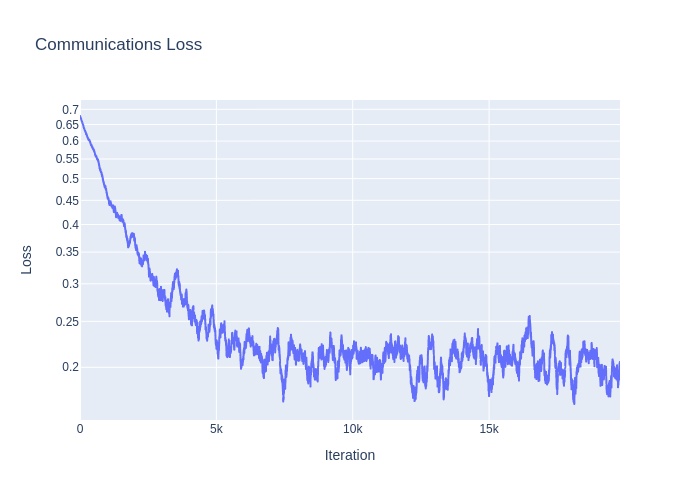

In [5]:
smoothing_interval = 200
training_df = pd.DataFrame(
    {
        "loss": np.convolve(
            losses,
            np.ones((smoothing_interval,)) / smoothing_interval,
            mode="valid",
        ),
        "iteration": list(range(len(losses[: -(smoothing_interval - 1)]))),
    },
)
fig = px.line(
    training_df,
    x="iteration",
    y="loss",
    log_y=True,
    title="Communications Loss",
    labels={"iteration": "Iteration", "loss": "Loss"},
)
Image(fig.to_image(format="png"))

Let's now define the algorithms under test, following a similar procedure to [Benchmark Algorithms](./benchmark_algorithms.ipynb).

We compare `DenseRadio` with a BPSK-DSSS algorithm that uses the optimal Barker-13 chip sequence.

In [6]:
barker_13 = torch.tensor([1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1])
modem = DSSS(barker_13)

test_algorithms = {
    "DSSS-BPSK": {"tx": Transmitter(modem.tx), "rx": Receiver(modem.rx)},
    "DenseRadio": {"tx": Transmitter(dense_radio.tx), "rx": Receiver(dense_radio.rx)},
}

transmitters, receivers = (
    {
        algorithm_name: algorithm[x]
        for algorithm_name, algorithm in test_algorithms.items()
    }
    for x in ["tx", "rx"]
)

In [7]:
def _analyze(device_logs: DeviceLogs, *, verbose: bool = False) -> dict[str, float]:
    # get transmitter and receiver names
    transmitter_names = list(device_logs.tx.keys())
    receiver_names = list(device_logs.rx.keys())

    # check device_logs only contain a single tx/rx pair
    assert len(transmitter_names) == 1
    assert len(receiver_names) == 1

    transmitter_name = transmitter_names[0]
    receiver_name = receiver_names[0]

    # transmitted and received bits
    original_bits = device_logs.tx[transmitter_name].metadata["bits"]
    recovered_bits = device_logs.rx[receiver_name]["bits"]
    matched_bits = recovered_bits == original_bits
    bit_error_rate = 1 - torch.mean(matched_bits.float()).item()

    # separate received signal and noise
    background_noise = device_logs.rx[receiver_name]["noise"]
    rx_pure_signal = device_logs.rx[receiver_name]["raw"] - background_noise
    snr = (
        10 * torch.log10(torch.var(rx_pure_signal) / torch.var(background_noise)).item()
    )

    # throughput
    n_bits = original_bits.shape[-1]
    signal_length = device_logs.tx[transmitter_name].signal.shape[-1]
    throughput = n_bits / signal_length

    if verbose:
        print(f"Basic Analysis for {transmitter_name} to {receiver_name}:")
        print(f"- Bit Error Rate: {100 * bit_error_rate:.2f}%")
        print(f"- SNR: {snr:.2f}dB")

    return {"Bit Error Rate": bit_error_rate, "SNR (dB)": snr, "Throughput": throughput}

We compare the algorithms' bit error rates from -20dB to 0dB.

In [8]:
test_env = ControlledSNREnvironment(0)
results_dict = {"Algorithm": []}
n_timesteps = 13**4
for snr in torch.linspace(-20, 0, 20):
    test_env.set_snr(snr)
    for algorithm_name, devices in test_algorithms.items():
        test_env.place(
            {f"{algorithm_name}-tx": devices["tx"]},
            {f"{algorithm_name}-rx": devices["rx"]},
        )
        device_logs = test_env.simulate(n_timesteps)
        result = _analyze(device_logs, verbose=False)

        results_dict["Algorithm"].append(algorithm_name)

        for k, v in result.items():
            if k not in results_dict:
                results_dict[k] = []
            results_dict[k].append(v)

Finally, we visualize the results. We notice that the two algorithms exhibit very similar performance. There is no need to compare throughput, as they have the same throughput by design.

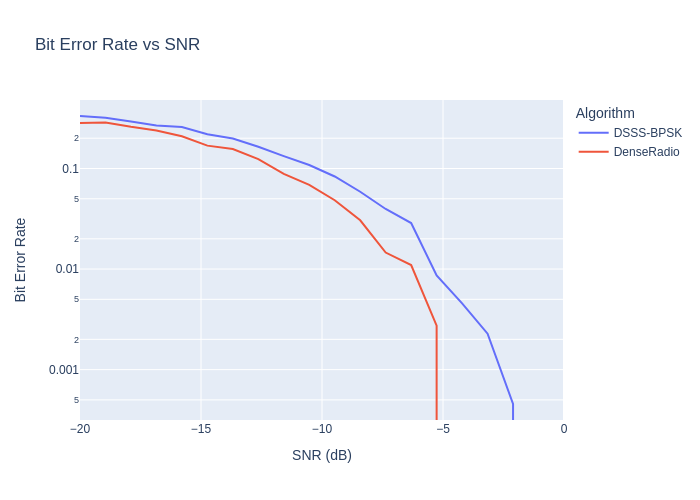

In [9]:
results_df = pd.DataFrame(results_dict)

fig = px.line(
    results_df,
    x="SNR (dB)",
    y="Bit Error Rate",
    color="Algorithm",
    title="Bit Error Rate vs SNR",
    log_y=True,
)
Image(fig.to_image(format="png"))

We observe that the `DenseRadio` outperforms `DSSS-BPSK` in this case. Let's check that `DenseRadio` achives this improved bit error rate without comprimising on throughput.

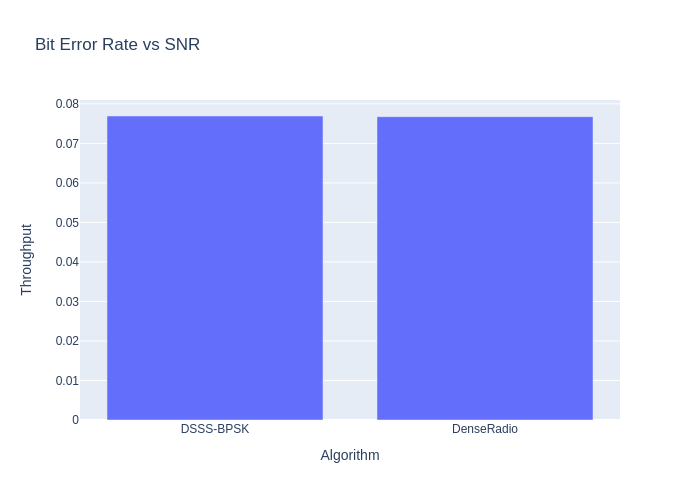

In [10]:
throughput_df = results_df.groupby("Algorithm")["Throughput"].mean().reset_index()
fig = px.bar(
    throughput_df,
    x="Algorithm",
    y="Throughput",
    log_y=False,
    title="Bit Error Rate vs SNR",
)
Image(fig.to_image(format="png"))